In [1]:
import os
import numpy as np
import xml.etree.cElementTree as et
import pandas as pd
from IPython.display import display, HTML
import math


In [78]:
import os
import numpy as np
import xml.etree.cElementTree as et
import pandas as pd
from IPython.display import display, HTML
from scipy.stats import mode
from datetime import datetime

class xml_data(object):
    def __init__(self, root, tree):
        self.root = root
        self.tree = tree
        
    #first class function return elements and ID's of tree
    def get_patient(self):
        '''get the Patient elem of tree'''
        BODY = self.root[0]
        for child in BODY:
            if 'Patient' in str(child):
                patient = child
        return(child)
    
    def get_study(self):
        patient = self.get_patient()
        for child in patient:
            if 'Study' in str(child):
                study = child
        return(study)

    def get_series(self):
        series = []
        study = self.get_study()
        for child in study:
            if 'Series' in str(child):
                series.append(child)
        return(series)
    def get_images(self):
        '''Get all image elements from xml'''
        Images = []
        series = self.get_series()
        for ser in series:
            for child in ser:
                if "Image" in child.tag and 'Num' not in child.tag:
                    Images.append(child)          
        return(Images)
    def get_patient_id(self):
        patient = self.get_patient()
        for child in patient:
            if 'PatientID' in str(child):
                patientID = child
        return patientID

    def get_study_id(self):
        study = self.get_study()
        for child in study:
            if 'ID' in str(child) and 'Study' not in str(child):
                studyID = child
        return studyID

    def get_series_id(self):
        series = self.get_series()
        for child in series:
            if 'Series' not in str(child) and 'Prog' not in str(child):
                seriesID = child
        return seriesID
    
    def get_parentmap(self):
        return(dict((c, p) for p in self.tree.getiterator() for c in p))
    
    def pID_orNAN(self):
        'This function returns the PatientID if exists otherwise Nan. Note that PatientID is the ID in DWH'
        patient = self.get_patient()
        l = []
        r = []
        for child in patient:
            if "PatientID" in str(child):
                l.append(child.text)
            if "PatientID" not in str(child):
                l.append("No PatientID")
            for i in l:
                if "No" not in i:
                    r.append(i)      
        if not r:
            r.append("NaN")
        return(r[0])
    
    ##Second series of function returns tables of data from XML tree##
    def get_patient_birthdate(self):
        patient = self.get_patient()
        for child in patient:
            if 'Birthdate' in str(child):
                date = child[0]
                for children in date:
                    if 'Year' in str(children):
                        year = children.text
                    if 'Month' in str(children):
                        month = children.text
                    if 'Day' in str(children):
                        day = children.text
    
        return('-'.join((year, month, day)))

    def get_study_date(self):
        '''return the date the study was made sa string'''
        study = self.get_study()
        for child in study:
            if 'StudyDate' in str(child):
                date = child[0]
                for children in date:
                    if 'Year' in str(children):
                        year = children.text
                    if 'Month' in str(children):
                        month = children.text
                    if 'Day' in str(children):
                        day = children.text

        return('-'.join((year, month, day)))
    
    def get_image_aquisition_time(self):
        '''return the date the study was made sa string'''
        image = self.get_images()
        for child in image:
            for children in child:
                if 'AcquisitionTime' in str(children):
                    print(children)
                    time = child[0]
                    for children in time:
                        if 'Hour' in str(children):
                            hour = children.text
                        if 'Minute' in str(children):
                            minute = children.text
                        if 'Second' in str(children):
                            second = children.text

        return('-'.join((hour, minute, second)))
    
    def get_thickness_grid_elem(self):
        '''the function returns the element representing the thickness grid'''
        thickness_grids = []
        series = self.get_series()
        for ser in series:
            for child in ser:
                if 'ThicknessGrid' in str(child):
                    thickness_grids.append(child)
        return(thickness_grids)
    
    def get_thicknessgrid(self):
        '''This function returns a pandas table with the Thickness grid for each series'''

        Type = []
        CentralThickness = []
        MinCentralThickness = []
        MaxCentralThickness = []
        TotalVolume = []
        X_cetner_pos = []
        Y_cetner_pos = []
        Series_ID = []
        parent_map = self.get_parentmap()
        series = self.get_series()
        for ser in series:
            for child in ser:
                if 'ThicknessGrid' in str(child):
                    series_id = parent_map[child]
                    Series_ID.append(series_id.findall('ID')[0].text)
                    #get direct children
                    Type.append(child.findall('Type')[0].text)
                    CentralThickness.append(child.findall('CentralThickness')[0].text)
                    MinCentralThickness.append(child.findall('MinCentralThickness')[0].text)
                    MaxCentralThickness.append(child.findall('MaxCentralThickness')[0].text)
                    TotalVolume.append(child.findall('TotalVolume')[0].text)

                    #get center position
                    center_pos = child.findall('CenterPos')[0]
                    for children in center_pos:
                        X_cetner_pos.append(children[0].text)
                        Y_cetner_pos.append(children[1].text)

        thicknessgrip_d = {'Series_ID': Series_ID, 'Type':Type,'CentralThickness':CentralThickness,\
                           'MinCentralThickness': MinCentralThickness,\
                        'MaxCentralThickness': MaxCentralThickness,'TotalVolume': TotalVolume,\
                        'X_cetner_pos':X_cetner_pos,'Y_cetner_pos':Y_cetner_pos}

        return(pd.DataFrame(data = thicknessgrip_d))
    
    def get_thicknessgrid_zones(self):
        '''This function return a pandas with thickness information for each zone'''
        Name = []
        AvgThickness = []
        Volume = []
        Series_ID = []
        thick_grid = self.get_thickness_grid_elem()
        parent_map = self.get_parentmap()
        for child in thick_grid:
            for children in child:
                if 'Zone' in str(children):
                    series = parent_map[parent_map[children]]
                    Series_ID.append(series.findall('ID')[0].text)
                    Name.append(children.findall('Name')[0].text)
                    AvgThickness.append(children.findall('AvgThickness')[0].text)
                    Volume.append(children.findall('Volume')[0].text)

        col = ['Series_ID','Name','AvgThickness','Volume']
        ThicknessGrid_df = pd.DataFrame([Series_ID,Name, AvgThickness, Volume]).T
        ThicknessGrid_df.columns = col
        return(ThicknessGrid_df)
    
    ######################################################################################################
    ##next section of class methods provides all table of information necessary for exploratory analysis##
    def get_patient_table(self):
        '''Returns PatientID_DB, Patient_ID, date, sex as pandas df'''
        patient =  self.get_patient()
        for child in patient:
            if "Sex" in str(child):
                sex = child.text
            if "ID" in str(child) and "Patient" not in str(child):
                ID = child.text
        PatientID = self.pID_orNAN()

        date = self.get_patient_birthdate()
        d = {'Patient_ID': [ID],'PatientID_DB': [PatientID], 'sex': [sex], 'date':[date]}
        return(pd.DataFrame(data = d))

    def get_study_table(self):
        '''Returns Patient_ID, Study_ID, study_date as pandas df'''
        PatientID = []
        study_date = self.get_study_date()
        parent_map = self.get_parentmap()
        study = self.get_study()
        for child in study:
            if 'ID' in str(child) and 'Study' not in str(child):
                study_ID = child.text
                patient_id = parent_map[parent_map[child]]
                #print(patient_id)
                PatientID.append(patient_id.findall('ID')[0].text)

        study_d = {'Patient_ID': PatientID,'Study_ID': [study_ID], 'study_date':[study_date]}
        return(pd.DataFrame(data = study_d))
    
    
    def get_series_table(self):
        Modality = []
        Laterality = []
        series_type = []
        NumImages = []
        ModalityProcedure = []
        parent_map = self.get_parentmap()
        study = self.get_study()
        for child in study:
            if 'Series' in str(child):
                for children in child:                
                    if 'Modality' in str(children) and 'Procedure' not in str(children):
                        Modality.append(children.text)
                    if 'ModalityProcedure' in str(children):
                        ModalityProcedure.append(children.text)
                    if 'Type' in str(children):
                        series_type.append(children.text)
                    if 'Laterality' in str(children):
                        Laterality.append(children.text)
                    if 'NumImages' in str(children):
                        NumImages.append(children.text)

        series_d = {'Modality': Modality,\
                    'ModalityProcedure':ModalityProcedure, \
                    'series_type': series_type,'laterality':Laterality, 'NumImages': NumImages}

        series_pd = pd.DataFrame(data = series_d)
        #thickness_pd = get_thicknessgrid(root, tree)

        return(series_pd)
    
    def get_image_table(self):
        parent_map = self.get_parentmap()
        series=self.get_series()
        image = self.get_images()
        series_list = []
        image_list = []
        series = []
        image_aq_time = []
        laterality = []
        type_list = []
        width = []
        height = []
        scaleX = []
        scaleY = []
        startx = []
        starty = []
        endx = []
        endy = []
        k = 0 
        for child in image:
            for children in child.findall("OphthalmicAcquisitionContext"):

                #in case of non OCT image, the start end wont we there and we append nan
                start_check = children.find('Start')
                if start_check is None:
                    startx.append(np.nan)
                    starty.append(np.nan)

                end_check = children.find('End')
                if end_check is None:
                    endx.append(np.nan)
                    endy.append(np.nan)

                for grand_children in children.findall("Width"):
                    width.append(grand_children.text)
                for grand_children in children.findall("Height"):
                    height.append(grand_children.text)
                for grand_children in children.findall("ScaleX"):
                    scaleX.append(grand_children.text)
                for grand_children in children.findall("ScaleY"):
                    scaleY.append(grand_children.text)   
                for grand_children in children.findall("Start"):
                    startx.append(grand_children[0][0].text)
                    starty.append(grand_children[0][1].text)
                for grand_children in children.findall("End"):
                    endx.append(grand_children[0][0].text)
                    endy.append(grand_children[0][1].text)

                series_elem = parent_map[child]
                #add series element for each isntance
                series.append(str(series_elem))
                image_id = child[0]
                for children in child.findall("AcquisitionTime"):
                    time = children[0]

                    for grand_child in time:
                        #print(grand_child)
                        if 'Hour' in str(grand_child):
                            hour = grand_child.text.zfill(2) 
                                
                        if 'Minute' in str(grand_child):
                            minute = grand_child.text.zfill(2) 
                            #print(minute)
                        if 'Second' in str(grand_child):
                            second = grand_child.text 
                            second = str(int(math.floor(float(second)))).zfill(2)

                    
                    image_aq_time.append('-'.join((hour, minute, second)))
                
                for children in child.findall("Laterality"):
                    laterality.append(children.text)
                for children in child.findall("ImageType"):
                    type_list.append(children[0].text)
                

                d = {'Image_aq_time':image_aq_time, "series":series\
                     , "Laterality":laterality, 'Image_type':type_list\
                    ,"Width":width, "Height": height, "scaleX": scaleX, "scaleY": scaleY\
                    ,"startx_pos":startx, "starty_pos":starty,"endx_pos":endx, "endy_pos":endy }
        return(pd.DataFrame(data = d))
    
    ##Below all table information are merged into final output##
    def complete_series(self):
        '''returns a merger of all tables containing series information above'''
        t_grid = self.get_thicknessgrid()
        z_grid = self.get_thicknessgrid_zones()
        s_table = self.get_series_table()
        #display(t_grid, z_grid)
        tz_grid = t_grid.merge(z_grid, left_on = 'Series_ID', right_on = 'Series_ID', how = 'left')
        #display(s_table, tz_grid)
        full_series = s_table.merge(tz_grid, left_on = 'series_ID', right_on = 'Series_ID', how = 'left')

        return(full_series)

    def get_explorative_data(self):
        series_complete = self.complete_series()
        study_table = self.get_study_table()
        patient_table = self.get_patient_table()
        #display(study_table,series_complete)
        #series_complete = series_complete.T.drop_duplicates().T
        study_series = study_table.merge(series_complete, left_on = 'Study_ID', right_on = 'Study_ID', how = 'left')
        study_series = study_series.T.drop_duplicates().T
        pat_st_ser = patient_table.merge(study_series, left_on = 'Patient_ID', right_on = 'Patient_ID',how = 'left')
        #pat_st_ser = pat_st_ser.T.drop_duplicates().T
        return(pat_st_ser)
    
    

In [79]:
#path is the path retrieved from iterating the whhole directors
path = '/media/olle/Seagate Expansion Drive/DRD_master_thesis_olle_holmberg/augen_clinic_data/image_data/68/2012-08-23'
#add standard name for xml to path
file_path = os.path.join(path, 'anom_explore_corrected_url.xml')
#make tree object and retrieve im_pd
tree = et.ElementTree()
tree.parse(file_path)
root = tree.getroot()
data  = xml_data(root, tree)
data.get_image_table()[() & ()]

,Height,Image_aq_time,Image_type,Laterality,Width,endx_pos,endy_pos,scaleX,scaleY,series,startx_pos,starty_pos
0,768,07-06-50,LOCALIZER,R,768,NaN,NaN,0.0116,0.0116,<Element 'Series' at 0x7ff39a542900>,NaN,NaN
1,496,07-06-50,OCT,R,768,8.921,4.460,0.0116,0.0039,<Element 'Series' at 0x7ff39a542900>,0.000,4.460
2,768,07-07-36,LOCALIZER,R,768,NaN,NaN,0.0116,0.0116,<Element 'Series' at 0x7ff39a66b750>,NaN,NaN
3,496,07-07-37,OCT,R,768,8.921,7.434,0.0116,0.0039,<Element 'Series' at 0x7ff39a66b750>,0.000,7.434
4,496,07-07-39,OCT,R,768,8.921,7.310,0.0116,0.0039,<Element 'Series' at 0x7ff39a66b750>,0.000,7.310
5,496,07-07-40,OCT,R,768,8.921,7.186,0.0116,0.0039,<Element 'Series' at 0x7ff39a66b750>,0.000,7.186
6,496,07-07-40,OCT,R,768,8.921,7.062,0.0116,0.0039,<Element 'Series' at 0x7ff39a66b750>,0.000,7.062
7,496,07-07-41,OCT,R,768,8.921,6.938,0.0116,0.0039,<Element 'Series' at 0x7ff39a66b750>,0.000,6.938
8,496,07-07-42,OCT,R,768,8.921,6.814,0.0116,0.0039,<Element 'Series' at 0x7ff39a66b750>,0.000,6.814
9,496,07-07-43,OCT,R,768,8.921,6.690,0.0116,0.0039,<Element 'Series' at 0x7ff39a66b750>,0.000,6.690


In [ ]:
datetime_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')


In [241]:
#path is the path retrieved from iterating the whhole directors
path = '/media/olle/Seagate Expansion Drive/DRD_master_thesis_olle_holmberg/augen_clinic_data/image_data/708/2011-08-12'
#add standard name for xml to path
file_path = os.path.join(path, 'anom_explore_corrected_url.xml')
#make tree object and retrieve im_pd
tree = et.ElementTree()
tree.parse(file_path)
root = tree.getroot()
data  = xml_data(root, tree)
im_pd = data.get_image_table()
# start retrieving the marked depth grid and y, x indices
LOC_dim = im_pd[im_pd["Image_type"] == "LOCALIZER"][["Width", "Height"]]
LOC_scale = im_pd[im_pd["Image_type"] == "LOCALIZER"][["scaleX", "scaleY"]]
OCT_dim = im_pd[im_pd["Image_type"] == "OCT"][["Width", "Height"]]


print(im_pd.columns)
# convert positional arguments from mm to pixels
OCT_pos_mm = im_pd[im_pd["Image_type"] == "OCT"][["startx_pos", "starty_pos", "endx_pos", "endy_pos"]] \
    .astype("float32")
'''NOW SCALING X AND Y ARGS BY Y_SCALE; OK NOW SINCE X AND Y SCALE ARE THE SAME'''
OCT_pos_pixel = (OCT_pos_mm / y_scale).astype("int32")
# include lateriality
OCT_pos_pixel["Laterality"] = im_pd["Laterality"]

Laterality = "L"
# create oct image paths
y_indices = OCT_pos_pixel.loc[OCT_pos_pixel['Laterality'] == Laterality][["starty_pos"]]
#set indices for later positional args
y_indices.index = range(1,y_indices.shape[0]+1)
x_indices = OCT_pos_pixel[["Laterality", "startx_pos", "endx_pos"]]
x_indices = x_indices.replace(0, np.nan)

x_indices = x_indices.interpolate(limit_direction='both')
# get integer value of start and end position of OCT scan
x_start = int(x_indices["startx_pos"].values[0])
x_end = int(x_indices["endx_pos"].values[0])
x_start, x_end
mode(y_indices)[0][0][0]

Index([u'Height', u'Image_aq_time', u'Image_type', u'Laterality', u'Width',
       u'endx_pos', u'endy_pos', u'scaleX', u'scaleY', u'startx_pos',
       u'starty_pos'],
      dtype='object')


686

In [138]:
#path is the path retrieved from iterating the whhole directors
path = '/home/olle/PycharmProjects/derive_depth_vector_and_map/data'
'''
Below script takes a path to an xml containg data of the left and right eye of on study. 
From the path and xml it produces a list of paths to all oct images that can be used to 
load and oct and predict segmentation from . These segmenattions can then be used to 
derive the depth vector which again in this script will be mapped to a HD depth map
using the scale and dimension information contained from each study.
'''
#add standard name for xml to path
file_path = os.path.join(path, 'anom_explore_corrected_url.xml')
#make tree object and retrieve im_pd
tree = et.ElementTree()
tree.parse(file_path)
root = tree.getroot()
data  = xml_data(root, tree)
# im_pd = data.get_image_table()
# im_pd

parent_map = data.get_parentmap()
series=data.get_series()
image = data.get_images()
series_list = []
image_list = []
image_aq_time = []
laterality = []
type_list = []
width = []
height = []
scaleX = []
scaleY = []
startx = []
starty = []
endx = []
endy = []
k = 0 
series=data.get_series()
image = data.get_images()
for child in image:
    for children in child.findall("OphthalmicAcquisitionContext"):
        
        #in case of non OCT image, the start end wont we there and we append nan
        start_check = children.find('Start')
        if start_check is None:
            startx.append(np.nan)
            starty.append(np.nan)
        
        end_check = children.find('End')
        if end_check is None:
            endx.append(np.nan)
            endy.append(np.nan)
        
        for grand_children in children.findall("Width"):
            width.append(grand_children.text)
        for grand_children in children.findall("Height"):
            height.append(grand_children.text)
        for grand_children in children.findall("ScaleX"):
            scaleX.append(grand_children.text)
        for grand_children in children.findall("ScaleY"):
            scaleY.append(grand_children.text)   
        for grand_children in children.findall("Start"):
            startx.append(grand_children[0][0].text)
            starty.append(grand_children[0][1].text)
        for grand_children in children.findall("End"):
            endx.append(grand_children[0][0].text)
            endy.append(grand_children[0][1].text)
        
        series_elem = parent_map[child]
        image_id = child[0]
        for children in child.findall("AcquisitionTime"):
            time = children[0]

            for grand_child in time:
                #print(grand_child)
                if 'Hour' in str(grand_child):
                    hour = grand_child.text
                if 'Minute' in str(grand_child):
                    minute = grand_child.text
                    #print(minute)
                if 'Second' in str(grand_child):
                    second = grand_child.text
                    second = str(math.floor(float(second)))

            image_aq_time.append('-'.join((hour, minute, second)))
        
        for children in child.findall("Laterality"):
            laterality.append(children.text)
        for children in child.findall("ImageType"):
            type_list.append(children[0].text)  

        d = {'Image_aq_time':image_aq_time\
             , "Laterality":laterality, 'Image_type':type_list\
            ,"Width":width, "Height": height, "scaleX": scaleX, "scaleY": scaleY\
            ,"startx_pos":startx, "starty_pos":starty}
pd.DataFrame(data = d)
#len(type_list)

,Height,Image_aq_time,Image_type,Laterality,Width,scaleX,scaleY,startx_pos,starty_pos
0,768,13-9-58.0,LOCALIZER,R,768,0.0113,0.0113,NaN,NaN
1,496,13-9-58.0,OCT,R,512,0.0113,0.0039,1.447,7.235
2,496,13-9-59.0,OCT,R,512,0.0113,0.0039,1.447,7.115
3,496,13-9-59.0,OCT,R,512,0.0113,0.0039,1.447,6.994
4,496,13-9-59.0,OCT,R,512,0.0113,0.0039,1.447,6.874
5,496,13-10-0.0,OCT,R,512,0.0113,0.0039,1.447,6.753
6,496,13-10-0.0,OCT,R,512,0.0113,0.0039,1.447,6.633
7,496,13-10-1.0,OCT,R,512,0.0113,0.0039,1.447,6.512
8,496,13-10-1.0,OCT,R,512,0.0113,0.0039,1.447,6.391
9,496,13-10-1.0,OCT,R,512,0.0113,0.0039,1.447,6.271


In [139]:
data.get_image_table()

<Element 'Image' at 0x7fdb71782c00>
<Element 'ID' at 0x7fdb71782b70>


IndexError: child index out of range

In [58]:
import re
import tensorflow as tf
from PIL import Image
%run /home/olle/PycharmProjects/derive_depth_vector_and_map/input_data.py
%run /home/olle/PycharmProjects/derive_depth_vector_and_map/model.py

img_height = 160
img_width = 400

logging_dir = '/home/olle/PycharmProjects/segmentation_OCT/logging_u_net_no_preprocc_dice/'

def unpadding_with_zeros(im, orig_shape, new_shape, batch_size):
    '''
    :param im:
    :param orig_shape:
    :param new_shape:
    :return:
    '''
    #    im = im.reshape(orig_shape)
    result = np.zeros(orig_shape)
    # print(new_shape[0],new_shape[1], orig_shape[0], orig_shape[1])
    x_offset = int((new_shape[0] - orig_shape[0]) / 2)  # 0 would be what you wanted
    y_offset = int((new_shape[1] - orig_shape[1]) / 2)  # 0 in your case
    #print(x_offset, y_offset)
    result = im[x_offset:im.shape[0] - x_offset, y_offset:im.shape[1] - y_offset]
    return (result)

#input placeholders
X = tf.placeholder(tf.float32, shape=[None, img_height,img_width, None], name='X')
y = tf.placeholder(tf.float32, shape=[None, img_height,img_width, None], name='y')

logits = u_net(X)
print("logits shape is {}".format(logits.get_shape()))

#create session
session = tf.Session()
#init global vars
init = tf.global_variables_initializer()
#preidction
prediction  = tf.argmax(tf.nn.softmax(logits), axis=1)
probability_map = tf.nn.softmax(logits)
#correct prediction
correct_prediction = tf.equal(prediction, tf.cast(tf.reshape(y,prediction.get_shape(),name=None), tf.int64))
#accuracy
accuracy_c = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
# Counter for total number of iterations performed so far.# Counte
total_iterations = 0
# Build the summary operation based on the TF collection of Summaries.
summary_op = tf.summary.merge_all()
# Start the queue runners.
tf.train.start_queue_runners(sess=session)
#set logging to specific location
summary_writer = tf.summary.FileWriter(logging_dir, session.graph)
# Create a saver.
saver = tf.train.Saver(tf.global_variables())

step_start = 0
try:
    ####Trying to find last checkpoint file fore full final model exist###
    print("Trying to restore last checkpoint ...")
    save_dir = logging_dir
    # Use TensorFlow to find the latest checkpoint - if any.
    last_chk_path = tf.train.latest_checkpoint(checkpoint_dir=save_dir)
    # Try and load the data in the checkpoint.
    saver.restore(session, save_path=last_chk_path)

    # If we get to this point, the checkpoint was successfully loaded.
    print("Restored checkpoint from:", last_chk_path)
    # get the step integer from restored path to start step from there
    uninitialized_vars = []
    for var in tf.global_variables():
        try:
            session.run(var)
        except tf.errors.FailedPreconditionError:
            uninitialized_vars.append(var)

    # create init op for the still unitilized variables
    init_new_vars_op = tf.variables_initializer(uninitialized_vars)
    session.run(init_new_vars_op)
except:
    # If all the above failed for some reason, simply
    # initialize all the variables for the TensorFlow graph.
    print("Failed to restore any checkpoints. Initializing variables instead.")
    session.run(init)

#path is the path retrieved from iterating the whhole directors
path = '/home/olle/PycharmProjects/derive_depth_vector_and_map/data'
'''
Below script takes a path to an xml containg data of the left and right eye of on study. 
From the path and xml it produces a list of paths to all oct images that can be used to 
load and oct and predict segmentation from . These segmenattions can then be used to 
derive the depth vector which again in this script will be mapped to a HD depth map
using the scale and dimension information contained from each study.
'''
#add standard name for xml to path
file_path = os.path.join(path, 'anom_explore_corrected_url.xml')
#make tree object and retrieve im_pd
tree = et.ElementTree()
tree.parse(file_path)
root = tree.getroot()
data  = xml_data(root, tree)
im_pd = data.get_image_table()

#start retrieving the marked depth grid and y, x indices
LOC_dim = im_pd[im_pd["Image_type"] == "LOCALIZER"][["Width", "Height"]]
LOC_scale = im_pd[im_pd["Image_type"] == "LOCALIZER"][["scaleX", "scaleY"]]
OCT_dim = im_pd[im_pd["Image_type"] == "OCT"][["Width", "Height"]]

#get dim of OCT image
x_dim = int(tuple(LOC_dim.loc[0])[0])
y_dim = int(tuple(LOC_dim.loc[0])[1])
#create grid for depth map
grid = np.zeros([x_dim, y_dim])

#get localizer scale
x_scale = float(LOC_scale.loc[0][0])
y_scale = float(LOC_scale.loc[0][1])

#convert positional arguments from mm to pixels
OCT_pos_mm = im_pd[im_pd["Image_type"] == "OCT"][["startx_pos","starty_pos","endx_pos","endy_pos"]]\
.astype("float32")
OCT_pos_pixel = (OCT_pos_mm / y_scale).astype("int32")
#include lateriality
OCT_pos_pixel["Laterality"] = im_pd["Laterality"]

Lateralities = ["R","L"]
for Laterality in Lateralities:
    #create oct image paths
    y_indices = OCT_pos_pixel.loc[OCT_pos_pixel['Laterality'] == Laterality]["starty_pos"]
    x_indices = OCT_pos_pixel[["Laterality","startx_pos","endx_pos"]]
    #get integer value of start and end position of OCT scan
    x_start = x_indices["startx_pos"].get(1)
    x_end = x_indices["endx_pos"].get(1)
    #derive paths to oct's and localizers
    oct_batch_path = os.path.join(path, "Volume", "OCT", Laterality)
    localizer_path = os.path.join(path, "Volume", "LOCALIZER", Laterality)
    localizer_timestamp = os.listdir(localizer_path)
    localizer_im_path = os.path.join(localizer_path, localizer_timestamp[0])
    oct_times = os.listdir(oct_batch_path)
    #list to gather oct slices for one fundus
    oct_slice = []
    for oct_time in oct_times:
        image_time_path = os.path.join(oct_batch_path, oct_time)
        oct_images = os.listdir(image_time_path)
        #get all oct slice paths for this fundus pic
        oct_per_fundus = []
        for oct_image in oct_images:
            if "DV" not in oct_image and "seg" not in oct_image:
                oct_path = os.path.join(image_time_path,oct_image)
                oct_per_fundus.append(oct_path)
            if "DV" in oct_image:
                '''
                here one can retrieve the OCT path for loading and prediction
                '''
                dv_path = os.path.join(image_time_path,oct_image)
                #print(dv_path)
                im_id = int(re.findall(r'\d+', oct_image)[0])
                '''
                replace loading of dv with prediction of seg map and derivation of dv
                '''
                dv = np.load(dv_path)
                #shift indices when laterilty changes to "L"
                if Laterality == "L":    
                    grid[y_indices[im_id+50], x_start:x_end] = dv
                if Laterality == "R":    
                    grid[y_indices[im_id], x_start:x_end] = dv
                #set all pixels for depth vectors to 1
        #gather all Oct slices in oct_slice list
        for oct_path in oct_per_fundus:
            im, new_shape, orig_shape = get_clinic_data_hardrive(oct_path, img_width, img_height)
            oct_slice.append(im)
        
    #prepare all images for segmentation
    image_array = np.asarray(oct_slice).reshape(len(oct_slice), img_height, img_width, 1)
    
    #list to gather all segmentations
    predictions = []
    for i in range(0, image_array.shape[0]):
        #segment every oct slice and gather segmentations in fundus
        feed_dict_train = {X: image_array[i].reshape(1,160,400,1)}
        #predict
        pred, prob_map = session.run([prediction, probability_map],
                                         feed_dict=feed_dict_train)
        predictions.append(pred)
    #ensure correct shape and type of the segmentations
    pred_array = np.asarray(predictions).reshape(len(oct_slice), img_height, img_width, 1).astype(np.int32)
    print(pred_array.shape[0])
    #reshape the segmentations to original shape
    im_batch = []
    #resize all images
    for i in range(0, pred.shape[0]):
        print(pred_array[i].shape, type(pred_array[i]))
        im_resized = np.asarray(Image.fromarray(pred_array[i]).resize([new_shape[1], new_shape[0]]))
        im_resized = unpadding_with_zeros(im_resized, orig_shape, new_shape, batch_size)
        im_batch.append(im_resized)
    im_batch = np.asarray(im_batch, dtype=np.int32).reshape(len(oct_slice), orig_shape[0], orig_shape[1])
    print(im_batch.shape)  
    
    #linearly intepolate missing values
    grid[grid==0] = np.nan
    grid_pd_int = pd.DataFrame(grid_test).interpolate(limit_direction='both')
    grid_pd_int= grid_pd_int.fillna(0)
                
    np.save(localizer_im_path+"/HD_depth_map", grid_pd_int)
                



logits shape is (64000, 2)
Trying to restore last checkpoint ...
('Restored checkpoint from:', u'/home/olle/PycharmProjects/segmentation_OCT/logging_u_net_no_preprocc_dice/model.ckpt-2900')
49
((), <type 'numpy.int64'>)


TypeError: Cannot handle this data type

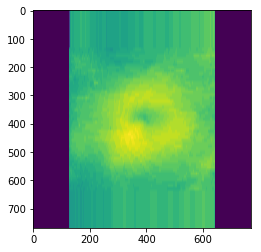

In [61]:
d = "/home/olle/PycharmProjects/derive_depth_vector_and_map/data/Volume/LOCALIZER/R/13-09-58"
f = "HD_depth_map.npy"
fi = os.path.join(d,f)

dm = np.load(fi)

plt.imshow(dm)

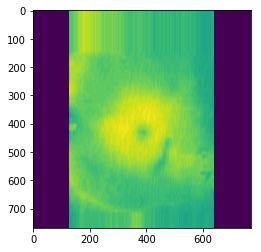

In [66]:
d = "/media/olle/Seagate Expansion Drive/DRD_master_thesis_olle_holmberg/augen_clinic_data/image_data/493/2016-06-02/Volume/LOCALIZER/L/08-14-27"
f = "HD_depth_map.npy"
fi = os.path.join(d,f)

dm = np.load(fi)

plt.imshow(dm)

In [63]:
np.zeros([2,1])

array([[0.],
       [0.]])